# Social Network: Reddit Hyperlink Network

In [ ]:
!wget https://snap.stanford.edu/data/soc-redditHyperlinks-body.tsv hyperlinks.tsv

--2024-04-13 18:26:34--  https://snap.stanford.edu/data/soc-redditHyperlinks-body.tsv
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 318931394 (304M) [text/tab-separated-values]
Saving to: ‘soc-redditHyperlinks-body.tsv’

soc-redditHyperlink 100%[===================>] 304.16M  41.2MB/s    in 7.6s    

2024-04-13 18:26:41 (40.0 MB/s) - ‘soc-redditHyperlinks-body.tsv’ saved [318931394/318931394]

--2024-04-13 18:26:41--  http://hyperlinks.tsv/
Resolving hyperlinks.tsv (hyperlinks.tsv)... failed: Name or service not known.
wget: unable to resolve host address ‘hyperlinks.tsv’
FINISHED --2024-04-13 18:26:42--
Total wall clock time: 7.8s
Downloaded: 1 files, 304M in 7.6s (40.0 MB/s)


In [ ]:
!wget https://snap.stanford.edu/data/web-redditEmbeddings-subreddits.csv subreddit.csv

--2024-04-13 18:26:42--  https://snap.stanford.edu/data/web-redditEmbeddings-subreddits.csv
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144814301 (138M) [text/csv]
Saving to: ‘web-redditEmbeddings-subreddits.csv’

web-redditEmbedding 100%[===================>] 138.11M  41.5MB/s    in 3.6s    

2024-04-13 18:26:45 (38.5 MB/s) - ‘web-redditEmbeddings-subreddits.csv’ saved [144814301/144814301]

--2024-04-13 18:26:45--  http://subreddit.csv/
Resolving subreddit.csv (subreddit.csv)... failed: Name or service not known.
wget: unable to resolve host address ‘subreddit.csv’
FINISHED --2024-04-13 18:26:45--
Total wall clock time: 3.7s
Downloaded: 1 files, 138M in 3.6s (38.5 MB/s)


In [ ]:
!pip install dgl
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 25.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data

In [2]:
sub = pd.read_csv('/content/web-redditEmbeddings-subreddits.csv', header=None)
sub['subredit_emb'] = sub.iloc[:, 1:].apply(lambda x: x.tolist(), axis=1)
sub.drop(sub.columns[1:301], axis=1, inplace=True)
sub.rename(columns={0: 'SUBREDDIT'}, inplace=True)
df_node_features = sub.copy()
df_node_features.head(5)

,SUBREDDIT,subredit_emb
0,spiders,"[0.158972, 0.285813, 0.226329, -0.183338, -0.1..."
1,askreddit,"[-0.499114, 0.323983, -0.424809, -0.222705, -0..."
2,globaloffensivetrade,"[-0.023145, -1.199374, 1.661484, -1.025296, 1...."
3,fireteams,"[2.492506, -2.529917, -0.448484, -3.543441, -0..."
4,funny,"[-0.81937, -0.865261, 0.301753, 0.018787, 0.20..."


In [3]:
df = pd.read_csv('/content/soc-redditHyperlinks-body.tsv', sep='\t')
df['PROPERTIES'] = df['PROPERTIES'].apply(lambda x: [float(val) for val in x.split(',')])
print(df.shape)
df.head(5)

(286561, 6)


,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"[345.0, 298.0, 0.75652173913, 0.0173913043478,..."
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"[101.0, 98.0, 0.742574257426, 0.019801980198, ..."
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"[85.0, 85.0, 0.752941176471, 0.0235294117647, ..."
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"[1124.0, 949.0, 0.772241992883, 0.001779359430..."
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"[715.0, 622.0, 0.777622377622, 0.0069930069930..."


In [ ]:
G = nx.Graph()

# Add nodes from SOURCE_SUBREDDIT and TARGET_SUBREDDIT columns
G.add_nodes_from(df['SOURCE_SUBREDDIT'], bipartite=0)
G.add_nodes_from(df['TARGET_SUBREDDIT'], bipartite=1)

# Add edges with features and labels
for idx, row in df.iterrows():
    source = row['SOURCE_SUBREDDIT']
    target = row['TARGET_SUBREDDIT']
    properties = row['PROPERTIES']
    sentiment = row['LINK_SENTIMENT']
    G.add_edge(source, target, features=properties, sentiment=sentiment)

positive_edges = [(u, v) for u, v, d in G.edges(data=True) if d['sentiment'] == 1]
negative_edges = [(u, v) for u, v, d in G.edges(data=True) if d['sentiment'] == -1]

In [ ]:
degrees = dict(G.degree())
largest_degree = max(degrees.values())
average_degree = sum(degrees.values()) / len(degrees)
print("Largest Degree:", largest_degree)
print("Average Degree:", average_degree)

Largest Degree: 2336
Average Degree: 6.950469588550984


In [ ]:
# Calculate the percentage of negative edges
total_edges = G.number_of_edges()
total_negative_edges = len(negative_edges)
percentage_negative_edges = (total_negative_edges / total_edges) * 100
print("Percentage of negative edges:", percentage_negative_edges)

# Create a new graph with sampled edges
sampled_positive_edges = random.sample(positive_edges, 1000)
sampled_negative_edges = random.sample(negative_edges, 70)
new_G = nx.Graph()
new_G.add_edges_from(sampled_positive_edges)
new_G.add_edges_from(sampled_negative_edges)
for node in G.nodes:
    if node in new_G.nodes:
        new_G.nodes[node].update(G.nodes[node])

Percentage of negative edges: 7.272581034344085


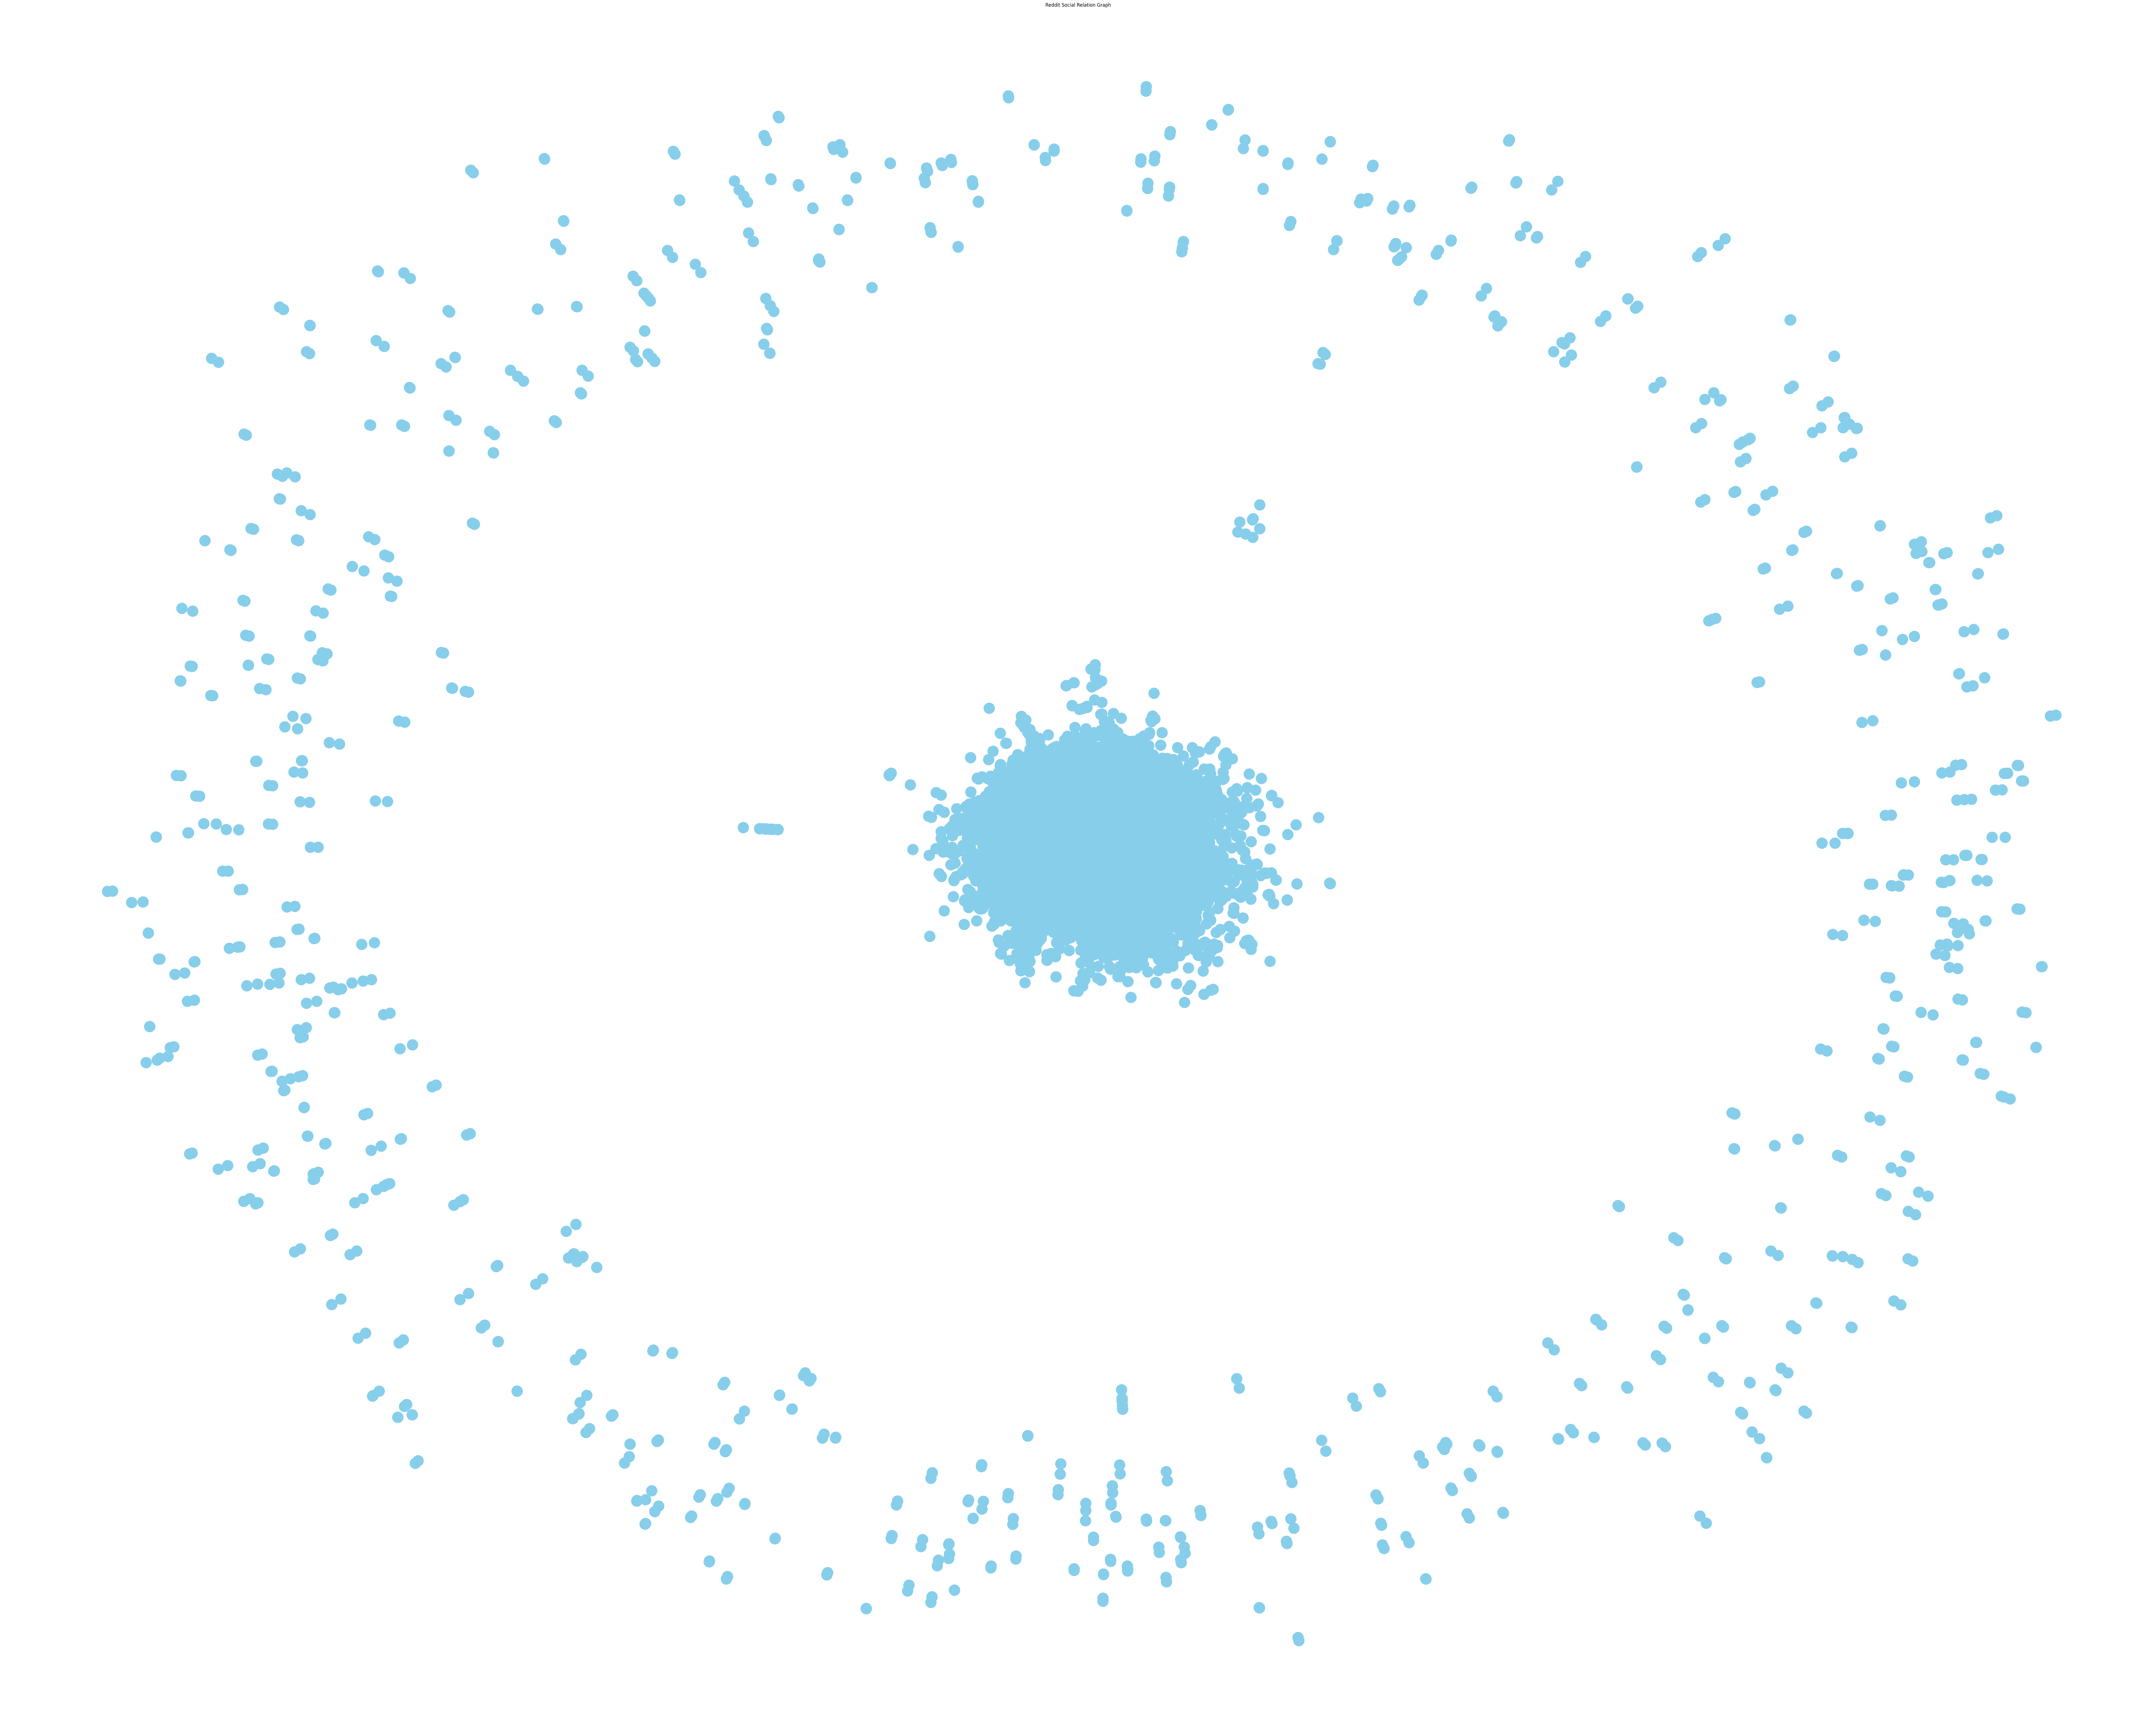

In [ ]:
plt.figure(figsize=(100, 80))
pos = nx.spring_layout(G, weight='PROPERTIES')
nx.draw_networkx_nodes(G, pos, node_size=800, node_color='skyblue')
nx.draw_networkx_edges(G, pos, edgelist=sampled_positive_edges, width=10, edge_color='green')
nx.draw_networkx_edges(G, pos, edgelist=sampled_negative_edges, width=10, edge_color='red', alpha=0.5)
#nx.draw_networkx_labels(new_G, pos, font_size=30, font_family='sans-serif')
plt.title('Reddit Social Relation Graph')
plt.axis('off')
plt.show()

# Model

In [4]:
import dgl
import torch
import torch.nn.functional as F
from torch_geometric.nn import GraphSAGE, GATConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split

### Construct graph data

In [7]:
df_edges = df.copy()
threshold_degree = 100

# Filter nodes with degrees greater than 3
source_subreddit_counts = df_edges['SOURCE_SUBREDDIT'].value_counts()
target_subreddit_counts = df_edges['TARGET_SUBREDDIT'].value_counts()
valid_nodes = set(source_subreddit_counts[source_subreddit_counts > threshold_degree].index) | set(target_subreddit_counts[target_subreddit_counts > threshold_degree].index)

# Filter edges based on valid nodes
filtered_edges = df_edges[(df_edges['SOURCE_SUBREDDIT'].isin(valid_nodes)) & (df_edges['TARGET_SUBREDDIT'].isin(valid_nodes))]

# Construct the graph
src = filtered_edges['SOURCE_SUBREDDIT'].astype('category').cat.codes.values.copy()
dst = filtered_edges['TARGET_SUBREDDIT'].astype('category').cat.codes.values.copy()
edge_g = dgl.graph((src, dst))

# Assign node features
edge_g.ndata['subreddit_emb'] = torch.zeros(edge_g.number_of_nodes(), 300)
subreddit_embeddings = dict(zip(df_node_features['SUBREDDIT'], df_node_features['subredit_emb']))
node_indices_mapping = {subreddit: node_index for subreddit, node_index in zip(filtered_edges['SOURCE_SUBREDDIT'], src)}
for subreddit, node_index in node_indices_mapping.items():
    if subreddit in subreddit_embeddings:
        node_emb = torch.tensor(subreddit_embeddings[subreddit])
        edge_g.ndata['subreddit_emb'][node_index] = node_emb

# Assign edge features and labels
edge_g.edata['feature'] = torch.tensor(filtered_edges['PROPERTIES'].tolist(), dtype=torch.float)
edge_g.edata['label'] = torch.tensor(filtered_edges['LINK_SENTIMENT'].values, dtype=torch.float)

# Synthetic train-validation-test splits
edge_g.edata['train_mask'] = torch.zeros(edge_g.number_of_edges(), dtype=torch.bool).bernoulli(0.6)

print(edge_g)

Graph(num_nodes=622, num_edges=88022,
      ndata_schemes={'subreddit_emb': Scheme(shape=(300,), dtype=torch.float32)}
      edata_schemes={'feature': Scheme(shape=(86,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.float32), 'train_mask': Scheme(shape=(), dtype=torch.bool)})


### Split graph data

In [12]:
test_ratio = 0.2
validation_ratio = 0.3

####################################

src_nodes = edge_g.edges()[0]
dst_nodes = edge_g.edges()[1]
unique_nodes = np.unique(np.concatenate((src_nodes.numpy(), dst_nodes.numpy())))

# Shuffle the indices
random_indices = torch.randperm(len(unique_nodes))
# Calculate the number of nodes for each set
num_test_nodes = int(len(unique_nodes) * test_ratio)
num_validation_nodes = int(len(unique_nodes) * validation_ratio)
num_train_nodes = len(unique_nodes) - num_test_nodes - num_validation_nodes
# Assign nodes to each set based on shuffled indices
test_indices = random_indices[:num_test_nodes]
validation_indices = random_indices[num_test_nodes:num_test_nodes + num_validation_nodes]
train_indices = random_indices[num_test_nodes + num_validation_nodes:]
# Create masks for each set
test_mask = torch.tensor([node in test_indices for node in unique_nodes])
validation_mask = torch.tensor([node in validation_indices for node in unique_nodes])
train_mask = torch.tensor([node in train_indices for node in unique_nodes])

# Assign masks to the graph
edge_g.ndata['test_mask'] = test_mask
edge_g.ndata['val_mask'] = validation_mask
edge_g.ndata['train_mask'] = train_mask
print(edge_g)

Graph(num_nodes=622, num_edges=88022,
      ndata_schemes={'subreddit_emb': Scheme(shape=(300,), dtype=torch.float32), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={'feature': Scheme(shape=(86,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.float32), 'train_mask': Scheme(shape=(), dtype=torch.bool)})


In [15]:
EDGE_FEAT_DIM = edge_g.edata['feature'].shape[1]
NODE_FEAT_DIM = edge_g.ndata['subreddit_emb'].shape[1]

# Train set
train_mask = edge_g.ndata['train_mask']
train_graph = dgl.edge_subgraph(edge_g, train_mask)
train_node_features = train_graph.ndata['subreddit_emb']
train_edge_features = train_graph.edata['feature']
train_edge_labels = train_graph.edata['label']

# Val set
val_mask = edge_g.ndata['val_mask']
val_graph = dgl.edge_subgraph(edge_g, val_mask)
val_node_features = val_graph.ndata['subreddit_emb']
val_edge_features = val_graph.edata['feature']
val_edge_labels = val_graph.edata['label']

# Test set
test_mask = edge_g.ndata['test_mask']
test_graph = dgl.edge_subgraph(edge_g, test_mask)
test_node_features = test_graph.ndata['subreddit_emb']
test_edge_features = test_graph.edata['feature']
test_edge_labels = test_graph.edata['label']

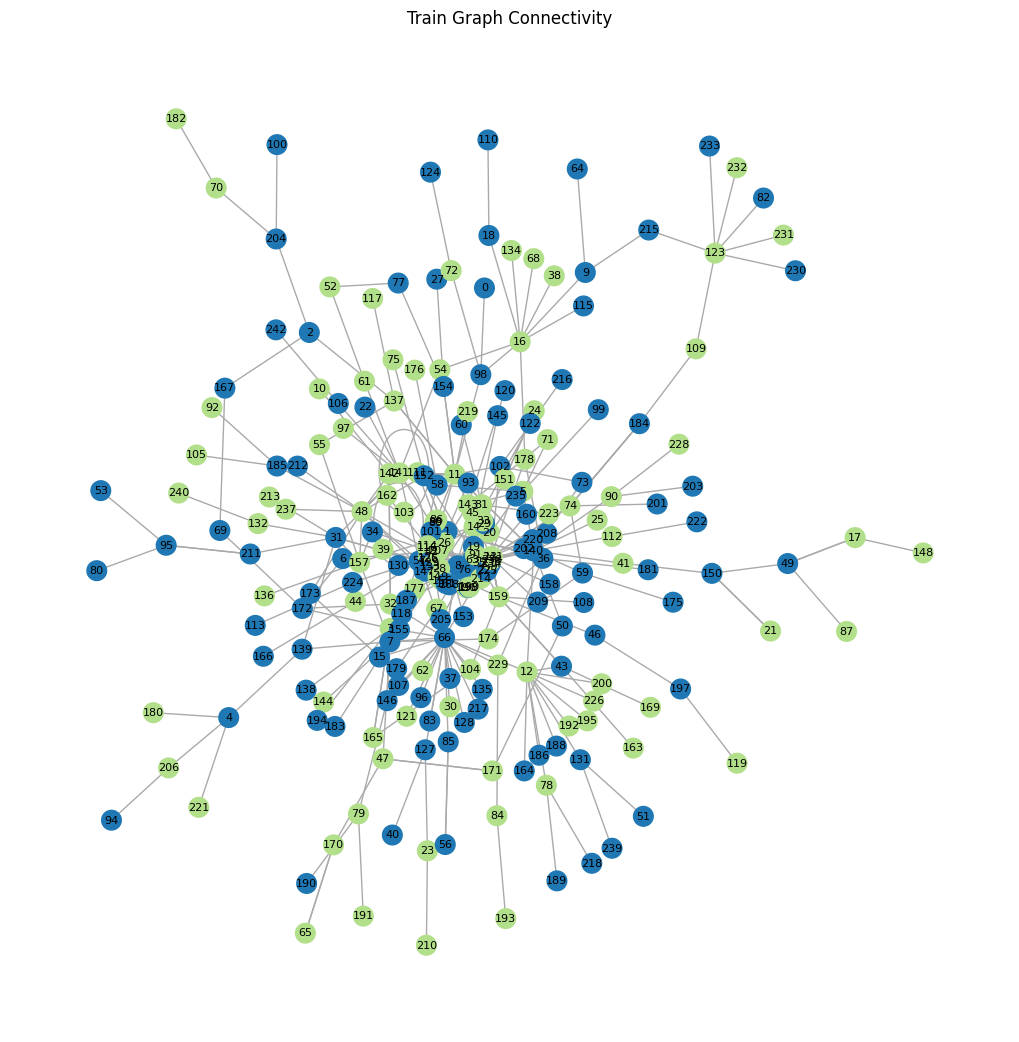

In [28]:
# Convert the DGL graph to a NetworkX graph
nx_graph = train_graph.to_networkx().to_undirected()
plt.figure(figsize=(10, 10))

node_colors = ['#1f78b4' if train_mask[node] else '#b2df8a' for node in nx_graph.nodes()]
layout = nx.kamada_kawai_layout(nx_graph)
nx.draw(nx_graph,
        pos=layout,              # Use the Kamada-Kawai layout
        with_labels=True,
        node_color=node_colors,
        node_size=200,
        edge_color='#aaaaaa',
        width=1.0,
        font_size=8,
        font_color='black'
       )
plt.title("Train Graph Connectivity")
plt.show()

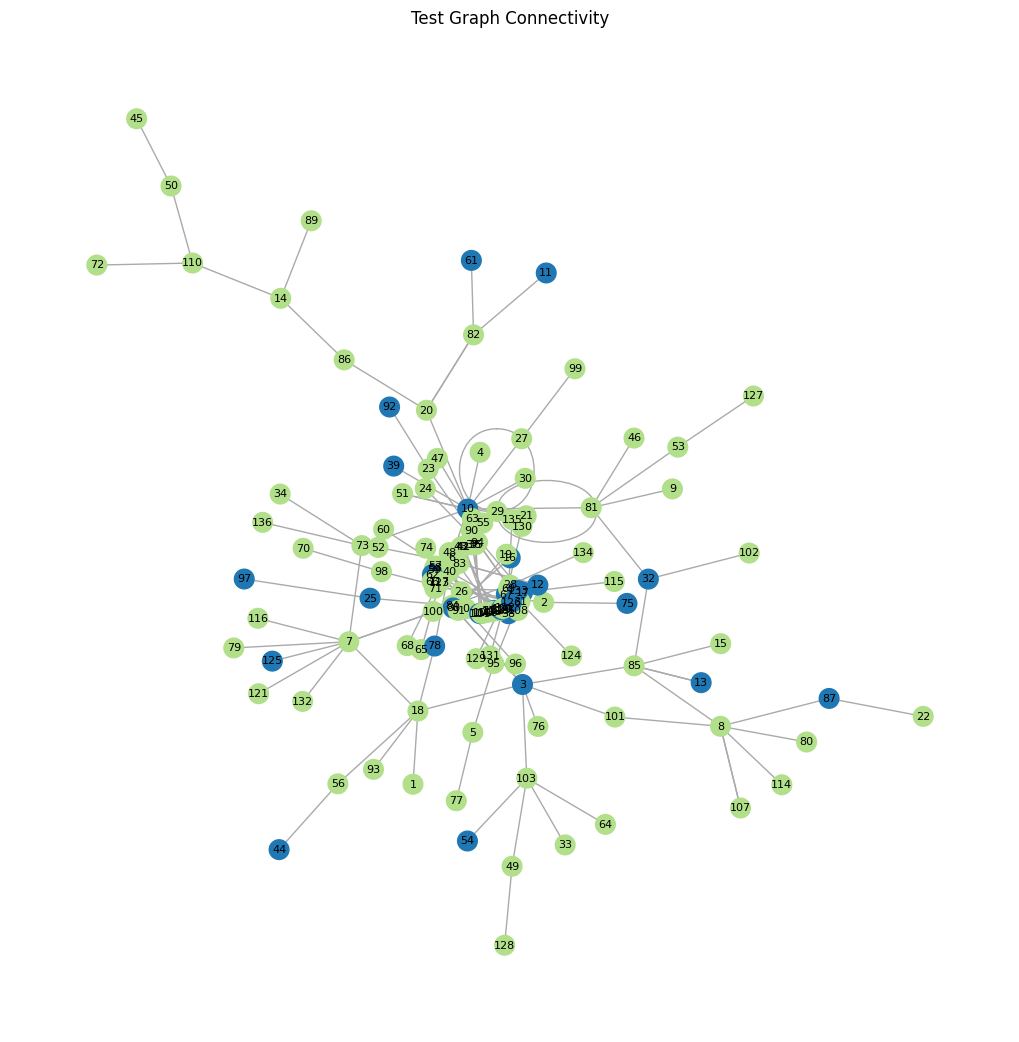

In [29]:
# Convert the DGL graph to a NetworkX graph
nx_graph = test_graph.to_networkx().to_undirected()
plt.figure(figsize=(10, 10))

node_colors = ['#1f78b4' if test_mask[node] else '#b2df8a' for node in nx_graph.nodes()]
layout = nx.kamada_kawai_layout(nx_graph)
nx.draw(nx_graph,
        pos=layout,              # Use the Kamada-Kawai layout
        with_labels=True,
        node_color=node_colors,
        node_size=200,
        edge_color='#aaaaaa',
        width=1.0,
        font_size=8,
        font_color='black'
       )
plt.title("Test Graph Connectivity")
plt.show()

### Model Architecture

In [10]:
import dgl.function as fn
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F

class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h

class DotProductPredictor(nn.Module):
    def forward(self, graph, h):
        # h contains the node representations computed from the GNN
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return graph.edata['score']

class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.sage = SAGE(in_features, hidden_features, out_features)
        self.pred = DotProductPredictor()
    def forward(self, g, x):
        h = self.sage(g, x)
        return self.pred(g, h)

### Start training

In [17]:
model = Model(NODE_FEAT_DIM, 20, 2)
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 300

#############################################
train_accs = []
val_accs = []
losses = []

for epoch in range(num_epochs):
    model.train()
    train_pred = model(train_graph, train_node_features)
    loss = ((train_pred - train_edge_labels) ** 2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    val_pred = model(val_graph, val_node_features)

    pred_train_labels = torch.sign(train_pred).squeeze()
    pred_val_labels = torch.sign(val_pred).squeeze()

    train_accuracy = (pred_train_labels == train_edge_labels).float().mean().item()
    val_accuracy = (pred_val_labels == val_edge_labels).float().mean().item()

    train_accs.append(train_accuracy)
    val_accs.append(val_accuracy)
    losses.append(loss.detach().numpy())

    print(f'epoch {epoch+1}')
    print(f'- train acc: {train_accuracy} | val acc: {val_accuracy}')
    print('- loss:', loss.item())

epoch 1
- train acc: 0.7115384340286255 | val acc: 0.6451612710952759
- loss: 14.400383949279785
epoch 2
- train acc: 0.682692289352417 | val acc: 0.5322580933570862
- loss: 6.762078762054443
epoch 3
- train acc: 0.6121794581413269 | val acc: 0.49462366104125977
- loss: 4.391941070556641
epoch 4
- train acc: 0.557692289352417 | val acc: 0.46236559748649597
- loss: 3.779343843460083
epoch 5
- train acc: 0.5352563858032227 | val acc: 0.4354838728904724
- loss: 3.6443891525268555
epoch 6
- train acc: 0.5064102411270142 | val acc: 0.4354838728904724
- loss: 3.5300140380859375
epoch 7
- train acc: 0.4967948794364929 | val acc: 0.4354838728904724
- loss: 3.326195001602173
epoch 8
- train acc: 0.49358972907066345 | val acc: 0.44086021184921265
- loss: 3.0709121227264404
epoch 9
- train acc: 0.5128205418586731 | val acc: 0.45698925852775574
- loss: 2.7956316471099854
epoch 10
- train acc: 0.5064102411270142 | val acc: 0.46236559748649597
- loss: 2.51792049407959
epoch 11
- train acc: 0.5320512

In [22]:
with torch.no_grad():
  model.eval()
  test_pred = model(test_graph, test_node_features)
  pred_test_labels = torch.sign(test_pred).squeeze()
  test_accuracy = (pred_test_labels == test_edge_labels).float().mean().item()
  print(f'test accuracy: {test_accuracy}')

test accuracy: 0.725806474685669


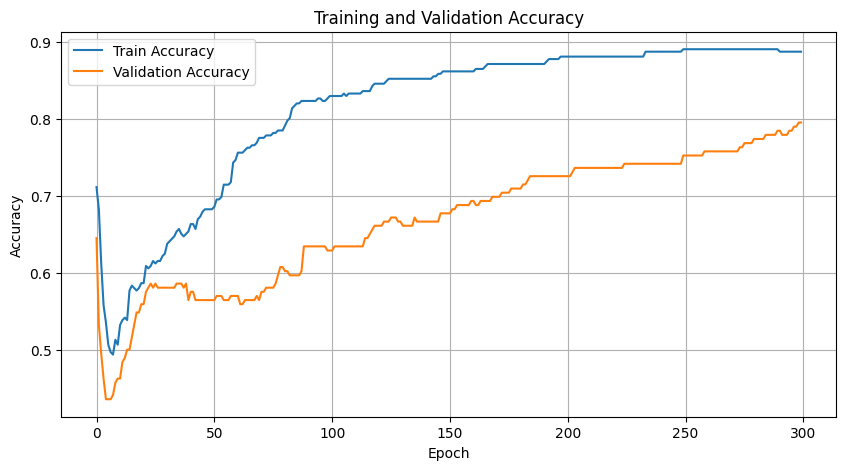

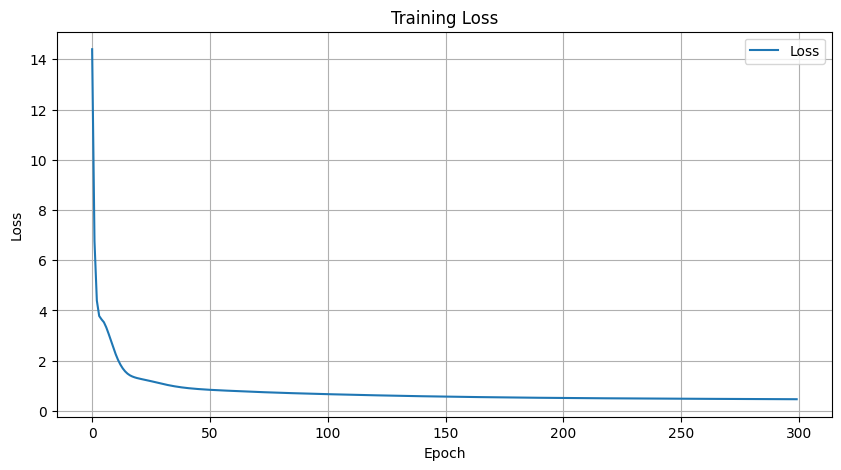

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

# Social LSTM (not within our scope)

In [ ]:
!wget https://snap.stanford.edu/conflict/conflict_data.zip -O conflict_data.zip

--2024-04-01 15:12:18--  https://snap.stanford.edu/conflict/conflict_data.zip
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1412333850 (1.3G) [application/zip]
Saving to: ‘conflict_data.zip’

conflict_data.zip   100%[===================>]   1.31G  35.7MB/s    in 43s     

2024-04-01 15:13:02 (31.1 MB/s) - ‘conflict_data.zip’ saved [1412333850/1412333850]



In [ ]:
from sklearn.model_selection import train_test_split

# Assuming you have already extracted node and edge features
X_edges = ...  # Edge features (e.g., concatenation of source and target node embeddings)
y_edges = ...  # Edge sentiments

# Split the data into train, validation, and test sets
X_train_edges, X_test_edges, y_train_edges, y_test_edges = train_test_split(X_edges, y_edges, test_size=0.2, random_state=42)


In [ ]:
!unzip conflict_data.zip

In [ ]:
import pickle
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
DATA_DIR = '/content/prediction'

In [ ]:
# loading handcrafted features
meta_features = {}
meta_labels = {}
with open(DATA_DIR+"/detailed_data/handcrafted_features.tsv") as fp:
    for line in fp:
        info = line.split()
        info_value = np.array(map(float, info[-1].split(",")))
        meta_features[info[0]] = list(info_value.tolist())
        meta_labels[info[0]] = 1 if info[1] == "burst" else 0

In [ ]:
# Assuming DATA_DIR contains the path to your data directory
with open(DATA_DIR + "/detailed_data/full_ids.txt") as fp:
    ids = {id.strip(): i for i, id in enumerate(fp.readlines())}

# Load the numpy array using 'rb' mode
all_embeds = np.load(DATA_DIR + "/detailed_data/full_embeds.npy")

In [ ]:
# loading the post embeddings from the LSTM
lstm_embeds = np.load(open(DATA_DIR + "/detailed_data/lstm_embeds.npy", 'rb'))
lstm_ids = pickle.load(open(DATA_DIR + "/detailed_data/lstm_embeds-ids.pkl", 'rb'))
lstm_ids = {id:i for i, id in enumerate(lstm_ids)}
lstm_ids = {key.decode('utf-8'): value for key, value in lstm_ids.items()}

In [ ]:
# loading preprocessed lstm data to ensure identical train/val/test splits
train_data = pickle.load(open(DATA_DIR + "/preprocessed_train_data.pkl", 'rb'))
val_data = pickle.load(open(DATA_DIR + "/preprocessed_val_data.pkl", 'rb'))
test_data = pickle.load(open(DATA_DIR + "/preprocessed_test_data.pkl", 'rb'))

<ipython-input-8-bb35757e8a89>:2: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  train_data = pickle.load(open(DATA_DIR + "/preprocessed_train_data.pkl", 'rb'))


In [ ]:
for batch in train_data:
    bids, btext, busers, bsubreddits, blengths, bsfs, blabels = batch
    bids = [ bid.decode('utf-8') for bid in bids ]
    print(bids)
    break

['24ga5l', '45394y', '4xtquo', '2khwmo', '3o4ciu', '337r83', '35rj34', '1x8t83', '3xgjdc', '5uxs6c', '2gus55', '3pc1sp', '3m6me1', '3igvek', '1wsirv', '5o85n6', '21l9ax', '4qi0mv', '1y4va6', '4l6slu', '2g2b8g', '469ddu', '575i3t', '3tfywb', '4euyok', '5mioit', '5fxg6d', '42v30g', '64swie', '20l080', '3ed5bo', '315uvr', '4x5rwh', '53svlq', '4jtuqw', '53tc06', '3ddh5c', '4d408e', '3hck37', '4eiv1c', '3aq1n7', '44wupw', '3mcib8', '3yeop5', '2ef5hh', '26bq7m', '5gv7y1', '1wnnp5', '55trbd', '2dc4qp', '3h3907', '4r7l77', '49jd50', '4768pm', '3omkp3', '3tt6a2', '34bvmq', '4ord0q', '2kaq9r', '3du3ck', '5x1z8y', '64sghr', '2swpnv', '4jsn6x', '5kxr06', '56jkh2', '2q7qj0', '2lmxj6', '4wv96j', '3jg2la', '5a67ml', '4fi5or', '1x772b', '4qch4a', '3c1zx8', '5a8fen', '51mlqa', '25arxi', '2do7n1', '4a2x8j', '2ni0nm', '28avh9', '1v9dsf', '65i33v', '3ydq2l', '53q3zp', '3sz3zv', '32favv', '2ve4w4', '3ae57r', '5g276w', '295f8s', '3aipnk', '30emql', '4e2tp6', '2apyej', '45yq7f', '25zou3', '5hccl8', '3wugfp',

In [ ]:
for batch in train_data:
    bids, btext, busers, bsubreddits, blengths, bsfs, blabels = batch
    print(bids[0])
    print(btext[0])
    print(busers[0])
    print(bsubreddits[0])
    print(blengths[0])
    print(bsfs[0])
    print(blabels[0])
    break

In [ ]:
# flattening the preprocessed LSTM data (no need for minibatching here....)
def flatten(data):
    ids, text, users, subreddits, lengths,sfs, labels = [], [], [], [], [], [], []
    for batch in data:
        bids, btext, busers, bsubreddits, blengths, bsfs, blabels = batch
        bids = [ bid.decode('utf-8') for bid in bids ]
        ids.extend(bids)
        text.extend(btext.numpy().tolist())
        users.extend(busers.numpy().tolist())
        subreddits.extend(bsubreddits.numpy().tolist())
        lengths.extend(blengths)
        labels.extend(blabels)
        sfs.extend(bsfs)
    return (ids, text, users, subreddits, lengths, labels)
# Convert byte string keys to regular strings for consistency
# ids = {key.decode('utf-8'): value for key, value in ids.items()}
# lstm_ids = {key.decode('utf-8'): value for key, value in lstm_ids.items()}

# Now continue with your code...
flat_train_data = flatten(train_data)
flat_val_data = flatten(val_data)
flat_test_data = flatten(test_data)

In [ ]:
for i in flat_train_data[0]:
  print(i)
  print(ids[i])
  print(lstm_embeds[lstm_ids[i]])
  data = meta_features[i]
  break

24ga5l
92104
[-0.0157285   0.01920039  0.06198497 -0.01200004 -0.36818832  0.19759224
  0.21285944  0.02540534 -0.00379212  0.08000418  0.08309538 -0.2500912
 -0.13043343 -0.33114764 -0.31451526 -0.01447714 -0.00683539 -0.29155236
 -0.21474522  0.08336415 -0.00622183 -0.03789938 -0.0119301  -0.12670736
 -0.24191953 -0.00314758 -0.07296221  0.01928577 -0.01361157 -0.2834255
  0.00064761  0.19701332 -0.01496982 -0.20345081 -0.16567579 -0.08027036
  0.00778298  0.02711659  0.256572   -0.02123477  0.05403448 -0.04190384
  0.05228071 -0.02937268  0.01102073 -0.18792321 -0.07906235 -0.13578223
 -0.02059896  0.03971994  0.01442715 -0.24262519 -0.01723938  0.00923876
  0.28026488  0.00832759  0.00679392  0.3376575   0.01540209 -0.0869553
 -0.02765656  0.39942932 -0.00066433 -0.04770507]


In [ ]:
train_X = np.stack([np.concatenate([meta_features[i], all_embeds[ids[i]], lstm_embeds[lstm_ids[i]]]) for i in flat_train_data[0]])
val_X =  np.stack([np.concatenate([meta_features[i], all_embeds[ids[i]], lstm_embeds[lstm_ids[i]]]) for i in flat_val_data[0] if i in meta_features])
test_X =  np.stack([np.concatenate([meta_features[i],all_embeds[ids[i]], lstm_embeds[lstm_ids[i]]]) for i in flat_test_data[0] if i in meta_features])

train_Y = np.stack([meta_labels[i] for i in flat_train_data[0] if i in meta_features])
val_Y =  np.stack([meta_labels[i] for i in flat_val_data[0] if i in meta_features])
test_Y =  np.stack([meta_labels[i] for i in flat_test_data[0] if i in meta_features])

In [ ]:
# First we run the Random Forest with only the metadata/handcrafted features...
baseline_mod = RandomForestClassifier(n_estimators=500, n_jobs=100, random_state=0)
# note that the first 263 features are the handcrafted ones...
baseline_mod.fit(train_X[:, :263], train_Y)

RandomForestClassifier(n_estimators=500, n_jobs=100, random_state=0)

In [ ]:
# For reference, on the authors server we get 0.682
roc_auc_score(val_Y, baseline_mod.predict_proba(val_X[:, :263])[:,1])

0.6823914377654168

In [ ]:
# For reference, on the authors server we get 0.667
roc_auc_score(test_Y, baseline_mod.predict_proba(test_X[:, :263])[:,1])

In [ ]:
# First we run the Random Forest with only the metadata/handcrafted features...
ensemble_mod = RandomForestClassifier(n_estimators=500, n_jobs=100, random_state=0)
# note that the first 263 features are the handcrafted ones...
ensemble_mod.fit(train_X[:, :], train_Y)

In [ ]:
# For reference, on the authors server we get 0.765
roc_auc_score(val_Y, ensemble_mod.predict_proba(val_X[:, :])[:,1])

In [ ]:
# For reference, on the authors server we get 0.756
roc_auc_score(test_Y, ensemble_mod.predict_proba(test_X[:, :])[:,1])

In [ ]:
df = pd.read_csv('/content/prediction/detailed_data/post_crosslinks_info.tsv', sep='\t', header=None)
df.head(10)

In [ ]:
df.iloc[0][4]

'1u4lo2T2013-12-31 16:11:17=1u4lgiT2013-12-31 16:08:24'

In [ ]:
hand_feat = pd.read_csv('/content/prediction/detailed_data/handcrafted_features.tsv', sep='\t', header=None)
hand_feat.head(5)

,0,1,2
0,39nlwk,burst,"578.0,493.0,0.787197231834,0.00692041522491,0...."
1,4kesnd,burst,"143.0,137.0,0.769230769231,0.027972027972,0.06..."
2,30wtjd,burst,"3854.0,3322.0,0.786974571873,0.0077841203944,0..."
3,5uid7j,burst,"8400.0,6989.0,0.789880952381,0.00166666666667,..."
4,3tu8r6,burst,"2734.0,2247.0,0.756400877835,0.00987564008778,..."


In [ ]:
label_info = pd.read_csv('/content/prediction/detailed_data/label_info.tsv', sep='\t', header=None)
label_info.sample(20)

,0,1
223374,"('36rvmz', '36rrfh')",non-burst
138374,"('3pfn6n', '3p2am4')",non-burst
5802,"('2v177p', '2v0zw1')",non-burst
96740,"('2w0ar0', '2vt7de')",non-burst
272481,"('3kbh7b', '2w3w7m')",non-burst
156762,"('5as47s', '5a6q01')",non-burst
39474,"('350o98', '2zy07z')",non-burst
365266,"('5t5sfq', '5t2osy')",non-burst
153078,"('2kh7p6', '1zxdxe')",non-burst
149653,"('53r3bt', '50zy0y')",non-burst


In [ ]:
label_info = label_info.rename(columns={0: 'edges', 1: 'relation'})
sample = label_info.sample(100)

In [ ]:
burst = label_info[label_info['relation'] == 'burst']
sample = burst.sample(100)

In [ ]:
degrees = dict(G.degree())
print("Node degrees:", degrees)

# Get edges of the graph
edges = list(G.edges())
print("Edges:", edges)

Node degrees: {'2evo8m': 1, '2eicft': 1, '321pfl': 1, '30wizq': 1, '47873c': 1, '42rgrp': 1, '2rhr4n': 1, '2ramva': 1, '37o11a': 1, '1xdhqm': 1, '3qlwz0': 1, '3qmnh3': 1, '2e56nz': 1, '2e54cg': 1, '3nfokk': 1, '3neqq4': 1, '3b2lsj': 1, '2omi4m': 1, '66m3xy': 1, '66ic6j': 1, '4nde36': 1, '4na7fl': 1, '1uok68': 1, '1ugokm': 1, '4xmg5j': 1, '4xx74x': 1, '3gu6wc': 1, '2xe4n3': 1, '5adh7t': 1, '5acvb7': 1, '3v2xkg': 1, '3v29m3': 1, '43qq8t': 1, '36fh4r': 1, '539457': 1, '536vj6': 1, '1vukfn': 1, '1vq4nx': 1, '4ctpap': 1, '4cq0d2': 1, '2g2syv': 1, '2dvptn': 1, '66g5dq': 1, '66cboq': 1, '4qtlwd': 1, '4ilhrc': 1, '2iatf4': 1, '2idliq': 1, '4mqxn9': 1, '4mlprq': 1, '2ar75j': 1, '2aqanh': 1, '5knda7': 1, '5kn8w0': 1, '26fn24': 1, '26evov': 1, '2auhsx': 1, '2ar6ru': 1, '3g4p8c': 1, '3gletn': 1, '2agvvq': 1, '29wo1v': 1, '4eaefp': 1, '3gwz64': 1, '240sl2': 1, '212x2s': 1, '4ngjwb': 1, '4fippf': 1, '3o1tox': 1, '3nnsle': 1, '3ruo72': 1, '3rum98': 1, '26vde1': 1, '26uwei': 1, '4a4xew': 1, '4a3pym': 

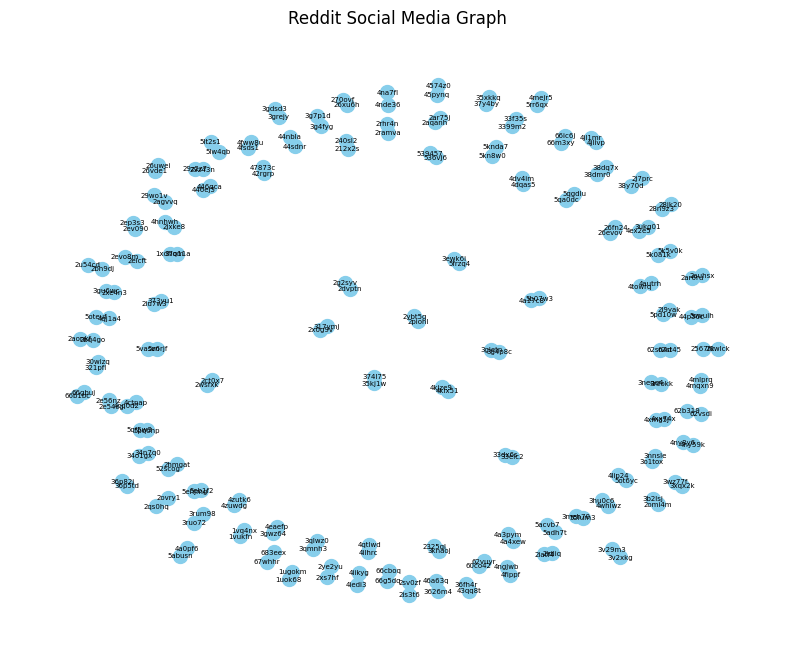

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import ast

df = sample
G = nx.Graph()

for index, row in df.iterrows():
    edge = ast.literal_eval(row['edges'])
    burst = row['relation']
    G.add_edge(edge[0], edge[1], burst=burst)

# Create lists of edges for each type of burst/non-burst
burst_edges = [(u, v) for u, v, d in G.edges(data=True) if d['burst'] == 'burst']
non_burst_edges = [(u, v) for u, v, d in G.edges(data=True) if d['burst'] == 'non-burst']


# Draw graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # Positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=100, node_color='skyblue')  # Draw nodes
nx.draw_networkx_edges(G, pos, edgelist=burst_edges, width=5, edge_color='red')  # Draw burst edges
nx.draw_networkx_edges(G, pos, edgelist=non_burst_edges, width=1, edge_color='black', alpha=0.5)  # Draw non-burst edges
nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')  # Draw labels
plt.title('Reddit Social Media Graph')
plt.axis('off')  # Turn off axis
plt.show()
